In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import shutil
from tqdm import tqdm
from PIL import Image
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler


In [2]:
def create_tsne(df):
    # Select the numerical columns from the DataFrame
    numerical_columns = df.select_dtypes(include=[np.float64])

    # Perform T-SNE on the numerical columns
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(numerical_columns)
    
    return tsne, tsne_results

In [3]:
def save_tsne_visual(df, name, ill_dir):
    # сохраняет результаты tsne в виде картинки
    # name - название файла, ill_dir - где создать (illustration_directory)
    tsne, tsne_results = create_tsne(df)
    
    # Create a new DataFrame with the T-SNE results
    tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

    # Optional: If you have labels or categories in your DataFrame, you can include them in the T-SNE DataFrame
    tsne_df['label'] = df['label']

    # Visualize the T-SNE results
    for label in tsne_df["label"].unique():
        plt.scatter(
            tsne_df["TSNE1"][tsne_df["label"]==label],
            tsne_df["TSNE2"][tsne_df["label"]==label],
            label=label
        )
    
    plt.xlabel('TSNE1')
    plt.ylabel('TSNE2')
    plt.title('T-SNE Visualization')
    plt.legend()
    
    # Save the visualization as an image
    filename = os.path.join(ill_dir, f"{name}.png")
    plt.savefig(filename)
    plt.close()

In [5]:
def save_clusters_by_column2(df, dst, cluster_col, cluster_nums):
    # в dst (destination) создает папки с названиями 
    # номеров кластеров и копирует картинки туда, 
    # cluster_col - колонка, с номерами кластеров (не название)
    # к каждому имени картинки прикрепляет его ранг
    # сохраняет в dst csv файл с датафреймом о кластеризации
    # возвращает датафрейм с колонками: номер кластера, 
    # среднее, стандартное отклонение по каждому рангу,
    # кол-во картинок определенного ранга для каждого ранга
    
    if not os.path.exists(dst):
        os.makedirs(dst)
    else:
        shutil.rmtree(dst)
        os.makedirs(dst)
    
    means = []
    stds = []
    nums = {
        0: [],
        1: [],
        2: [],
        3: []
    }
    
    for cluster_num in cluster_nums:
        cl_df = df[cluster_col==cluster_num]
        cl_rating_df = cl_df["rating"]
        
        for i in range(4):
            nums[i].append(cl_df[cl_rating_df == i]["id"].count())
            
        
        cl_mean = cl_rating_df.mean()
        cl_std = cl_rating_df.std()
        
        means.append(cl_mean)
        stds.append(cl_std)
        
        cl_dir_name = str(cluster_num) + f"[mean_{cl_mean}][std_{cl_std}]"
        cl_dir_path = os.path.join(dst, cl_dir_name)
        
        os.mkdir(os.path.join(dst, cl_dir_name))
        cl_df = df[cluster_col==cluster_num]
        cl_df[["id", "rating", "img_generation_promt"]].to_csv(os.path.join(cl_dir_path, "cl_info.csv"), index=False)
        for index, row in cl_df.iterrows():
            shutil.copyfile(row["img_path"], os.path.join(cl_dir_path, 
                                                          os.path.basename(row["img_path"])+f"[{row['rating']}]"))
        
    return pd.DataFrame({
        "cluster": cluster_nums,
        "mean": means,
        "std": stds,
        **nums
    })

In [6]:
full_set = pd.read_csv("full_set.csv")

In [7]:
emb_dir = "embeddings"
ill_dir = "t_sne_illustrations"

In [ ]:
# for csv_name in tqdm(os.listdir(emb_dir)):
#     name = csv_name.split(".")[0]
#     df = pd.read_csv(os.path.join(emb_dir, csv_name))
#     save_tsne_visual(
#         full_set[["id", "rating"]].merge(df, on="id").rename({
#             "rating": "label"
#         }, axis=1), name, ill_dir=ill_dir
#     )


<h1> ViT-B32_img </h1>

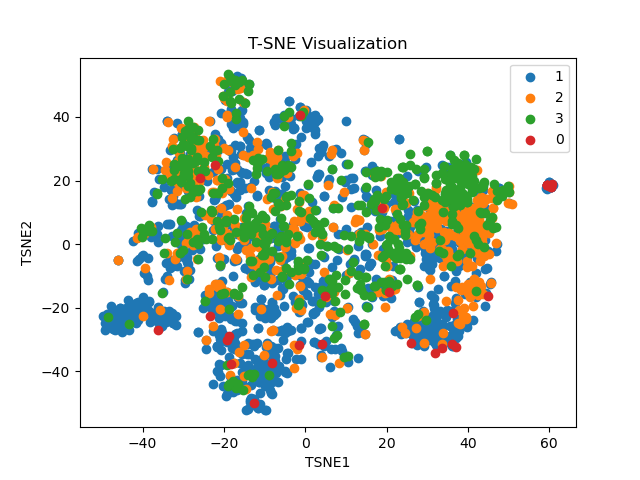

In [24]:
name = "ViT-B32_img"

df = pd.read_csv(os.path.join(emb_dir, f"{name}.csv"))

merged_df = full_set[["id", "rating"]].merge(df, on="id").rename(
    {
        "rating": "label"
    }, axis=1)

tsne, tsne_results = create_tsne(merged_df)

tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

Image.open(os.path.join(ill_dir, f"{name}.png"))

<h2> KMean on embeddings<h2>

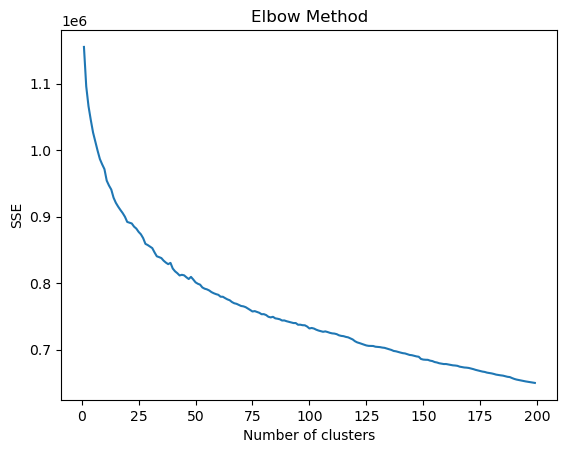

In [25]:
scaler = StandardScaler()
X = scaler.fit_transform(merged_df.select_dtypes(include=[np.float64]))

sse = []
for k in range(1, 200):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans.fit(X)
    sse.append(kmeans.inertia_)  

plt.plot(range(1, 200), sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()


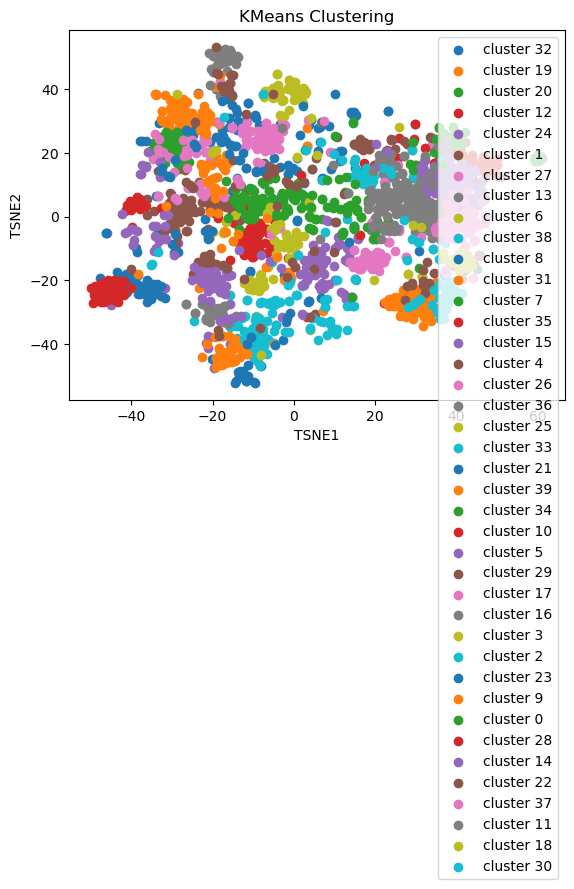

In [26]:
# Train KMeans on the numerical columns
n_clusters=40
kmeans = KMeans(n_clusters=n_clusters, n_init="auto", max_iter=1000, random_state=0)
clusters = kmeans.fit_predict(merged_df.select_dtypes(include=[np.float64]))

# Create a new DataFrame with the cluster labels
cluster_df = pd.DataFrame(clusters, columns=['cluster'])

combined_df = pd.concat([tsne_df, cluster_df], axis=1)
unique_clusters = combined_df['cluster'].unique()
scatter = []
for cluster in unique_clusters:
    cluster_data = combined_df[combined_df['cluster'] == cluster]
    plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], label=f'cluster {cluster}')

plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('KMeans Clustering')
plt.legend()

In [27]:
cl_infos = save_clusters_by_column2(full_set, os.path.join("clusters", name, "KMeans"), 
               combined_df['cluster'], 
               range(n_clusters))

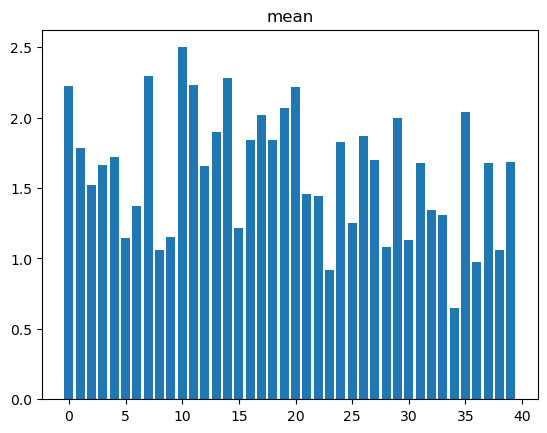

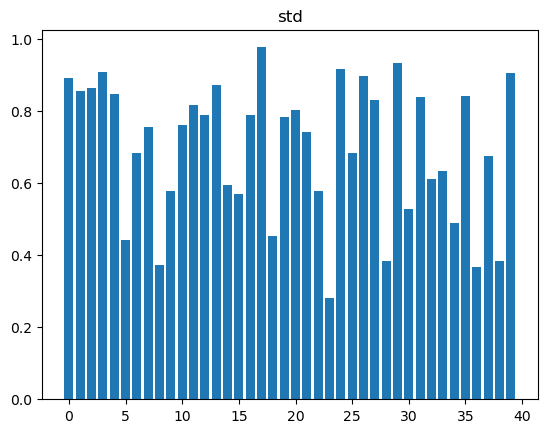

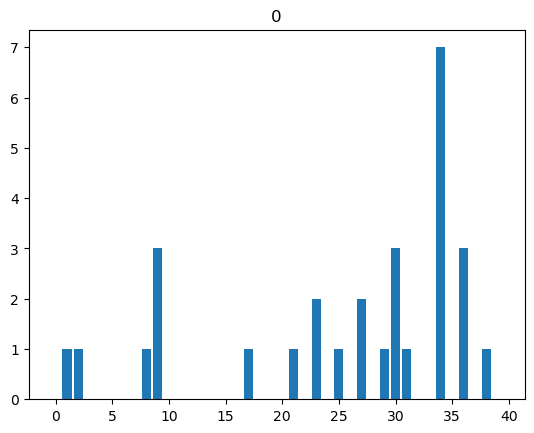

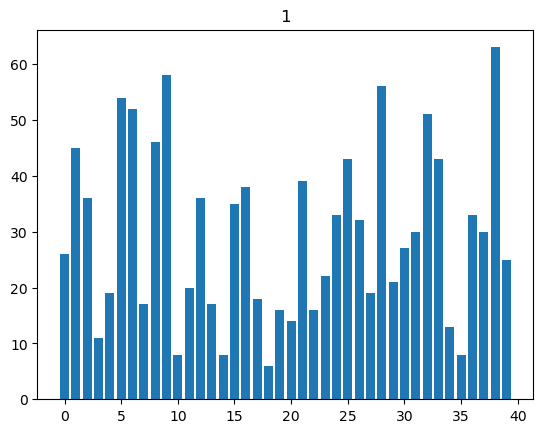

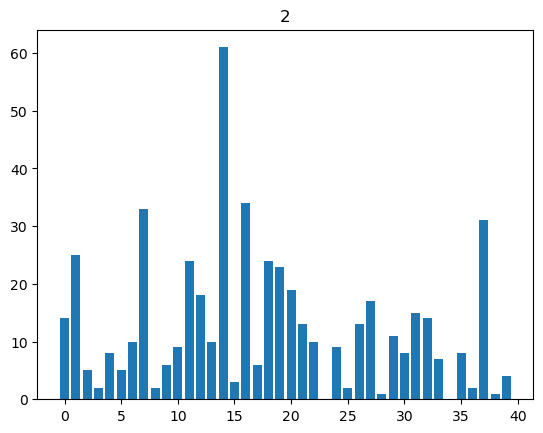

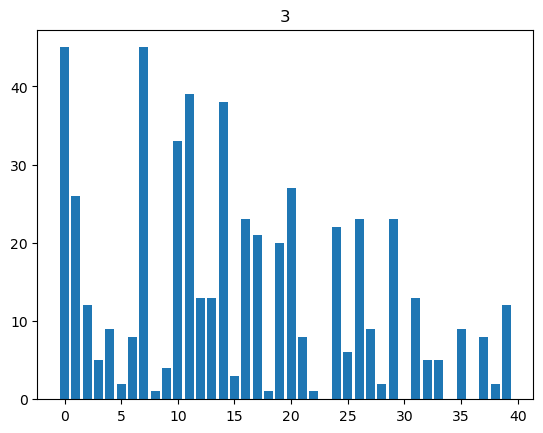

In [28]:
for i in ["mean", "std", 0, 1, 2, 3]:
    plt.bar(cl_infos["cluster"], cl_infos[i])
    plt.title(i)
    plt.show()

<h2> DBScan </h2>

In [ ]:
eps = 4 
min_samples = 7

# Train DBSCAN on the numerical columns
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(tsne_results)

# Create a new DataFrame with the cluster labels
cluster_df = pd.DataFrame(clusters, columns=['cluster'])

combined_df = pd.concat([tsne_df, cluster_df], axis=1)
unique_clusters = combined_df['cluster'].unique()
scatter = []
for cluster in unique_clusters:
    cluster_data = combined_df[combined_df['cluster'] == cluster]
    plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], label=f'cluster {cluster}')

plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('DBSCAN Clustering')
plt.legend()

In [ ]:
save_clusters_by_column2(full_set, 
               os.path.join("clusters", name, "DBScan"), 
               combined_df['cluster'], 
               [4])

<h1> RN50x4_img </h1>

In [ ]:
name = "RN50x4_img"
Image.open(os.path.join(ill_dir, f"{name}.png"))

In [ ]:
df = pd.read_csv(os.path.join(emb_dir, f"{name}.csv"))

merged_df = full_set[["id", "rating"]].merge(df, on="id").rename(
    {
        "rating": "label"
    }, axis=1)

tsne, tsne_results = create_tsne(merged_df)

tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

In [ ]:
eps = 4 
min_samples = 7

# Train DBSCAN on the numerical columns
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(tsne_results)

# Create a new DataFrame with the cluster labels
cluster_df = pd.DataFrame(clusters, columns=['cluster'])

combined_df = pd.concat([tsne_df, cluster_df], axis=1)
unique_clusters = combined_df['cluster'].unique()
scatter = []
for cluster in unique_clusters:
    cluster_data = combined_df[combined_df['cluster'] == cluster]
    plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], label=f'cluster {cluster}')

plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('DBSCAN Clustering')
plt.legend()

<h2> DBSCAN on tsne1, tsne2 </h2>

In [ ]:
eps = 4 
min_samples = 7

# Train DBSCAN on the numerical columns
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(tsne_results)

# Create a new DataFrame with the cluster labels
cluster_df = pd.DataFrame(clusters, columns=['cluster'])

combined_df = pd.concat([tsne_df, cluster_df], axis=1)
unique_clusters = combined_df['cluster'].unique()
scatter = []
for cluster in unique_clusters:
    cluster_data = combined_df[combined_df['cluster'] == cluster]
    plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], label=f'cluster {cluster}')

plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('KMeans Clustering')
plt.legend()

In [ ]:
save_clusters_by_column2(full_set, 
               os.path.join("clusters", name, "DBScan"), 
               combined_df['cluster'], 
               [1, 2, 3, 5])


<h2> KMean on tsne1, tsne2 </h2>


In [ ]:
kmeans = KMeans(n_clusters=8, n_init="auto", max_iter=1000)
clusters = kmeans.fit_predict(tsne_results)

# Create a new DataFrame with the cluster labels
cluster_df = pd.DataFrame(clusters, columns=['cluster'])

combined_df = pd.concat([tsne_df, cluster_df], axis=1)
unique_clusters = combined_df['cluster'].unique()
scatter = []
for cluster in unique_clusters:
    cluster_data = combined_df[combined_df['cluster'] == cluster]
    plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], label=f'cluster {cluster}')

plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('DBSCAN Clustering')
plt.legend()

<h2> KMeans on embeddins </h2>

In [ ]:
# Train KMeans on the numerical columns
kmeans = KMeans(n_clusters=10, n_init="auto", max_iter=1000)
clusters = kmeans.fit_predict(merged_df.select_dtypes(include=[np.float64]))

# Create a new DataFrame with the cluster labels
cluster_df = pd.DataFrame(clusters, columns=['cluster'])

combined_df = pd.concat([tsne_df, cluster_df], axis=1)
unique_clusters = combined_df['cluster'].unique()
scatter = []
for cluster in unique_clusters:
    cluster_data = combined_df[combined_df['cluster'] == cluster]
    plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], label=f'cluster {cluster}')

plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('KMeans Clustering')
plt.legend()

<h1> ViT-B32_both </h1>

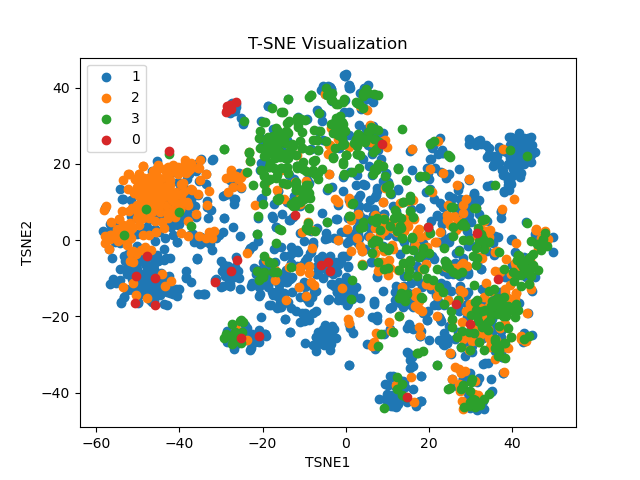

In [15]:
name = "ViT-B32_both"

df = pd.read_csv(os.path.join(emb_dir, f"{name}.csv"))

merged_df = full_set[["id", "rating"]].merge(df, on="id").rename(
    {
        "rating": "label"
    }, axis=1)

numerical_columns = merged_df.select_dtypes(include=[np.float64])

# Perform T-SNE on the numerical columns
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(numerical_columns)


tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

Image.open(os.path.join(ill_dir, f"{name}.png"))

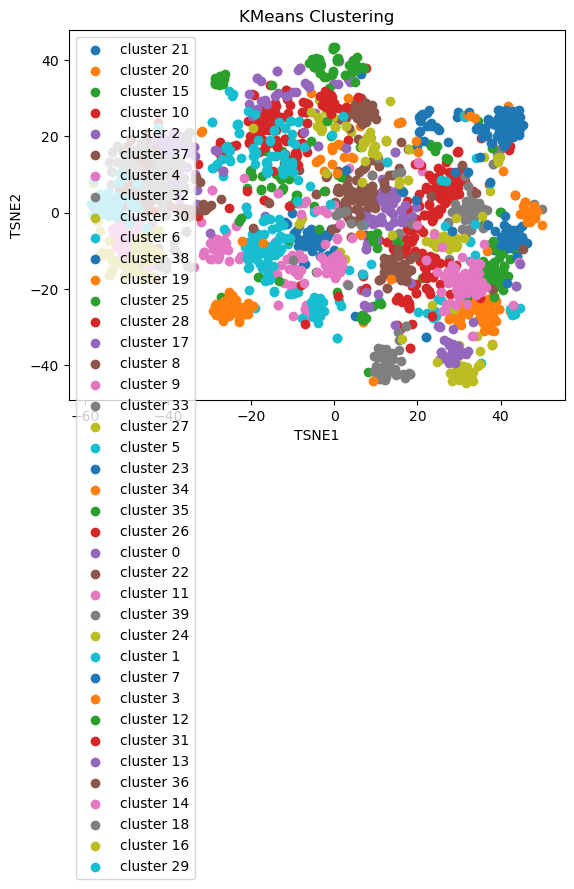

In [16]:
# Train KMeans on the numerical columns
n_clusters=40
kmeans = KMeans(n_clusters=n_clusters, n_init="auto", max_iter=1000, random_state=0)
clusters = kmeans.fit_predict(merged_df.select_dtypes(include=[np.float64]))

# Create a new DataFrame with the cluster labels
cluster_df = pd.DataFrame(clusters, columns=['cluster'])

combined_df = pd.concat([tsne_df, cluster_df], axis=1)
unique_clusters = combined_df['cluster'].unique()
scatter = []
for cluster in unique_clusters:
    cluster_data = combined_df[combined_df['cluster'] == cluster]
    plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], label=f'cluster {cluster}')

plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('KMeans Clustering')
plt.legend()

In [17]:
cl_infos = save_clusters_by_column2(full_set, os.path.join("clusters", name, "KMeans"), 
               combined_df['cluster'], 
               range(n_clusters))

In [18]:
cl_infos

,cluster,mean,std,0,1,2,3
0,0,2.083333,0.963887,0,20,4,24
1,1,2.438356,0.799067,0,14,13,46
2,2,2.058824,0.770392,0,18,28,22
3,3,1.433962,0.866235,2,37,3,11
4,4,1.059524,0.359088,2,76,5,1
5,5,1.347222,0.734650,0,58,3,11
6,6,1.200000,0.514205,0,51,6,3
7,7,1.065789,0.340021,0,73,1,2
8,8,1.750000,0.879049,0,30,10,16
9,9,2.000000,0.866025,2,15,21,19


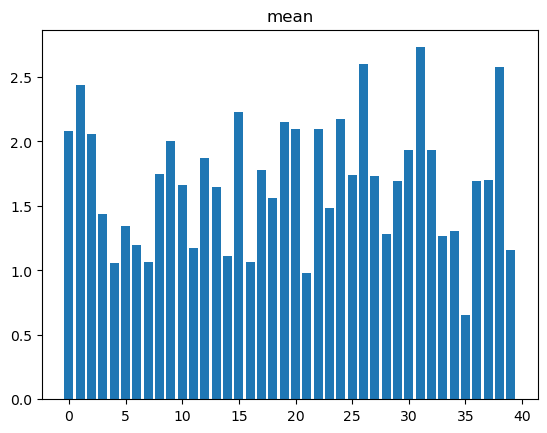

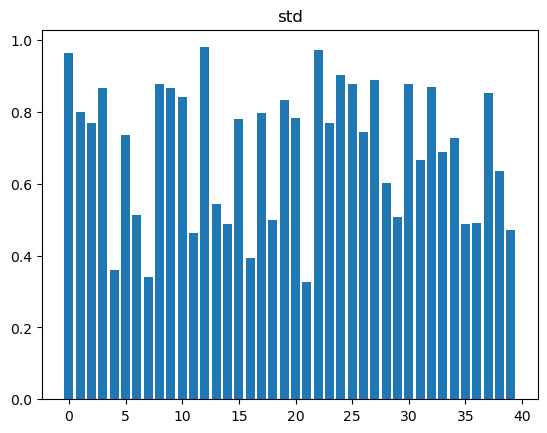

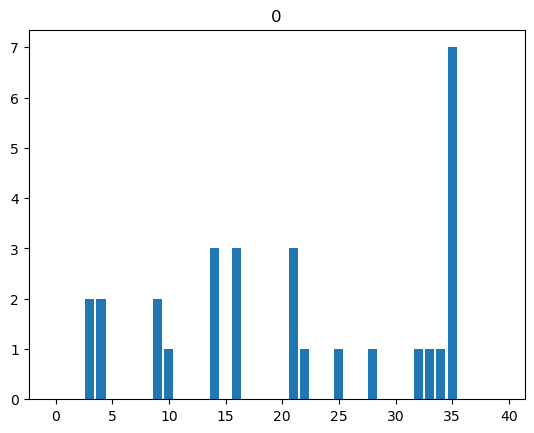

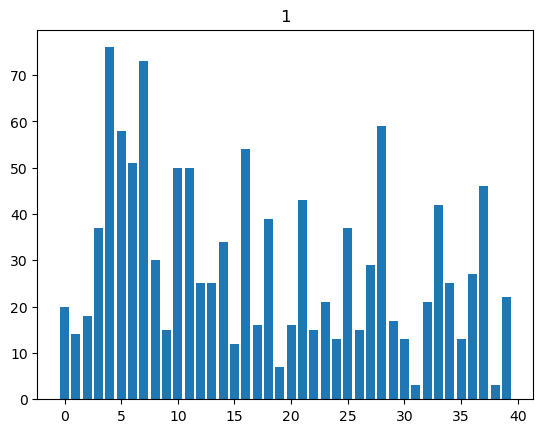

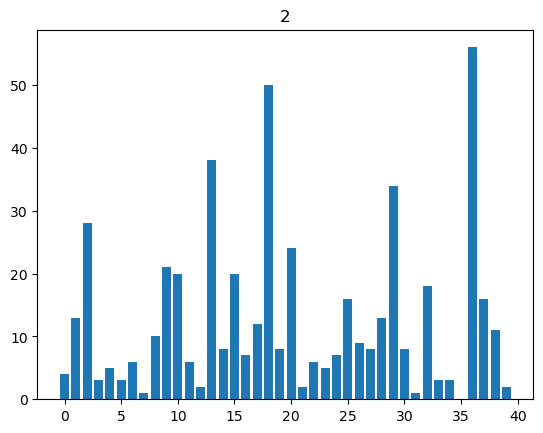

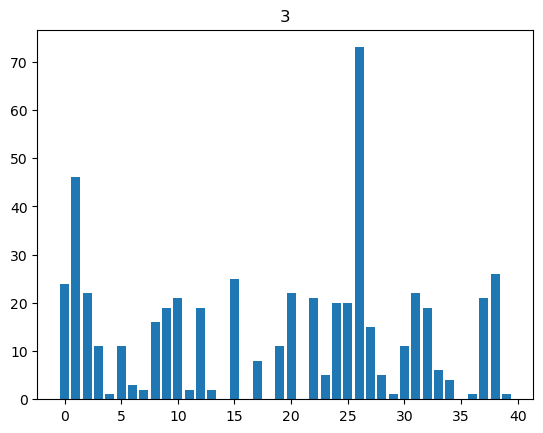

In [19]:
for i in ["mean", "std", 0, 1, 2, 3]:
    plt.bar(cl_infos["cluster"], cl_infos[i])
    plt.title(i)
    plt.show()